# Open and run analysis on multiple polygons <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Many users need to run analyses on their own areas of interest. 
A common use case involves running the same analysis across multiple polygons in a vector file (e.g. ESRI Shapefile or GeoJSON). 
This notebook will demonstrate how to use a vector file and the Open Data Cube to extract satellite data from Digital Earth Australia corresponding to individual polygon geometries.

## Description
If we have a vector file containing multiple polygons, we can use the python package [geopandas](https://geopandas.org/) to open it as a `GeoDataFrame`. 
We can then iterate through each geometry and extract satellite data corresponding with the extent of each geometry. 
Further anlaysis can then be conducted on each resulting `xarray.Dataset`.

We can retrieve data for each polygon, perform an analysis like calculating NDVI and plot the data.

1. First we open the polygon using `geopandas`
2. Iterate through  a geodatframe, extracting satellite data from DEA's ODC
3. Calculate NDVI as an example analysis on one of the extracted satellite timeseries.
4. Plot NDVI for the polygon extent

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube.utils` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand.

In [1]:
%matplotlib inline

import datacube
import rasterio.crs
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import geometry

import sys
sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import rgb, map_shapefile
from dea_temporaltools import time_buffer
from dea_spatialtools import xr_rasterize

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Australia data.

In [2]:
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc = datacube.Datacube(app='Analyse_multiple_polygons', env='c3-samples')
except:
    dc = datacube.Datacube(app='Analyse_multiple_polygons')

## Analysis parameters

* `time_of_interest` : Enter a time, in units YYYY-MM-DD, around which to load satellite data e.g. `'2019-01-01'`
* `time_buff` : A buffer of a given duration (e.g. days) around the time_of_interest parameter, e.g. `'30 days'`
* `vector_file` : A path to a vector file (ESRI Shapefile or GeoJSON)
* `attribute_col` : A column in the vector file used to label the output `xarray` datasets containing satellite images. Each row of this column should have a unique identifier
* `products` : A list of product names to load from the datacube e.g. `['ga_ls7e_ard_3', 'ga_ls8c_ard_3']`
* `measurements` : A list of band names to load from the satellite product e.g. `['nbart_red', 'nbart_green']`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Landsat, this is `(-30, 30)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection
* `align` : How to align the x, y coordinates respect to each pixel e.g. Landsat Collection 3 should be centre aligned `(15, 15)` 

In [3]:
time_of_interest = '2019-02-01'
time_buff = '30 days'

vector_file = '../Supplementary_data/Analyse_multiple_polygons/multiple_polys.shp'
attribute_col = 'id'

products = ['ga_ls8c_ard_3']
measurements = ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir']
resolution = (-30, 30)
output_crs = 'EPSG:3577'
align = (15, 15)

### Look at the structure of the vector file
Import the file and take a look at how the file is structured so we understand what we are iterating through. 
There are two polygons in the file:

In [4]:
gdf = gpd.read_file(vector_file)
gdf.head()

,id,geometry
0,2,"POLYGON ((980959.746 -3560845.144, 983880.024 ..."
1,1,"POLYGON ((974705.494 -3565359.492, 977625.771 ..."


We can then plot the `geopandas.GeoDataFrame` using the function `map_shapefile` to make sure it covers the area of interest we are concerned with:

In [5]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

### Create a datacube query object
We then create a dictionary that will contain the parameters that will be used to load data from the DEA data cube:

> **Note:** We do not include the usual `x` and `y` spatial query parameters here, as these will be taken directly from each of our vector polygon objects.

In [6]:
query = {'time': time_buffer(time_of_interest, buffer=time_buff),
         'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         'align': align,
         }

query

{'time': ('2019-01-02', '2019-03-03'),
 'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir'],
 'resolution': (-30, 30),
 'output_crs': 'EPSG:3577',
 'align': (15, 15)}

## Loading satellite data

Here we will iterate through each row of the `geopandas.GeoDataFrame` and load satellite data.  The results will be appended to a dictionary object which we can later inex to analyse each dataset.

In [7]:
# Dictionary to save results 
results = {}

# A progress indicator
i = 0

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iloc[0:2].iterrows():
    
    print(f'Feature: {i + 1}/{len(gdf)}')
    
    # Get the geometry
    try:
        # If on the DEA Sandbox
        geom = geometry.Geometry(row.geometry.__geo_interface__,
                                 geometry.CRS(gdf.crs))
    except:
        # If on the NCI
        crs_wkt = rasterio.crs.CRS(gdf.crs).to_wkt()
        geom = geometry.Geometry(row.geometry.__geo_interface__,
                                 geometry.CRS(crs_wkt))
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    # Load landsat
    ds = load_ard(dc=dc, 
                  products=products,
                  # min_gooddata=0.99,  # only take uncloudy scenes
                  ls7_slc_off = False,                  
                  group_by='solar_day',
                  **query)

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[attribute_col]) : ds})
    
    # Update counter
    i += 1

Feature: 1/2
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 3 observations 
Rasterizing to match xarray.DataArray dimensions (92, 105) and projection system/CRS (e.g. EPSG:3577)
Feature: 2/2
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 3 observations 
Rasterizing to match xarray.DataArray dimensions (92, 105) and projection system/CRS (e.g. EPSG:3577)


---
## Further analysis

Our `results` dictionary will contain `xarray` objects labelled by the unique `attribute column` values we specified in the `Analysis parameters` section:

In [8]:
results

{'2': <xarray.Dataset>
 Dimensions:      (time: 3, x: 105, y: 92)
 Coordinates:
   * x            (x) float64 9.808e+05 9.808e+05 ... 9.838e+05 9.839e+05
   * y            (y) float64 -3.561e+06 -3.561e+06 ... -3.564e+06 -3.564e+06
   * time         (time) datetime64[ns] 2019-01-17T00:20:13.792499 ... 2019-02-18T00:20:07.953681
 Data variables:
     nbart_red    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     nbart_green  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     nbart_blue   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
     nbart_nir    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     crs:      EPSG:3577, '1': <xarray.Dataset>
 Dimensions:      (time: 3, x: 105, y: 92)
 Coordinates:
   * x            (x) float64 9.745e+05 9.745e+05 ... 9.776e+05 9.776e+05
   * y            (y) float64 -3.565e+06 -3.565e+06 ... -3.568e+06 -3.568e+06
   * time         (time) datetime64[ns] 2019-01-17T00:20:13.792499 

Enter one of those values below to index our dictionary and conduct further analsyis on the satellite timeseries for that polygon.

In [9]:
key = '1'

### Plot an RGB image
We can now use the `dea_plotting.rgb` function to plot our loaded data as a three-band RGB plot:

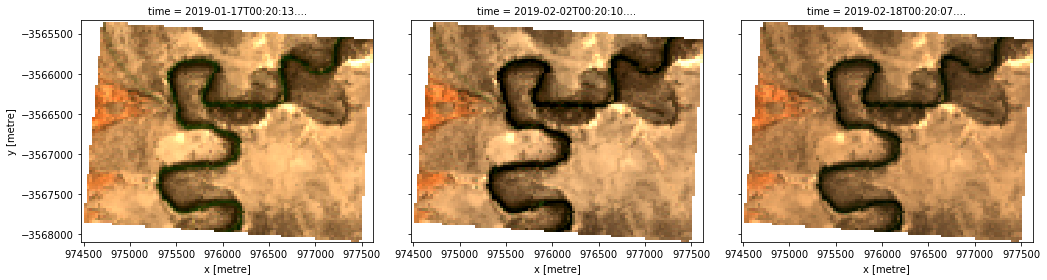

In [10]:
rgb(results[key], col='time', size=4)

### Calculate NDVI and plot
We can also apply analyses to data loaded for each of our polygons.
For example, we can calculate the Normalised Difference Vegetation Index (NDVI) to identify areas of growing vegetation:

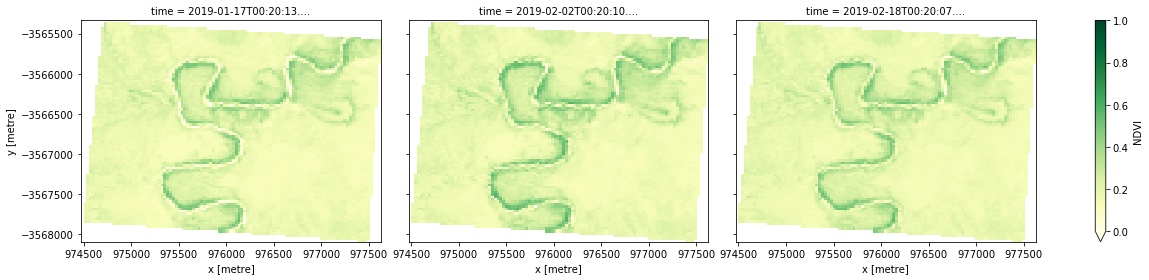

In [11]:
# Calculate band index
ndvi = calculate_indices(results[key], index='NDVI', collection='ga_ls_3')
        
# Plot NDVI for each polygon for the time query
ndvi.NDVI.plot(col='time', cmap='YlGn', vmin=0, vmax=1, figsize=(18, 4))
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)